In [ ]:
import pandas as pd
import gensim

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

import re
import numpy as np

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,Bidirectional
from keras.models import Model
from keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/AA2-DATASETS/hasoc_2020_en_train_new.csv", encoding= 'unicode_escape')
train_data.head()

,tweet_id,text,task1,task2,ID
0,1.123757e+18,hate wen females hit ah nigga with tht bro ???...,HOF,PRFN,hasoc_2020_en_2574
1,1.123733e+18,RT @airjunebug: When you're from the Bay but y...,HOF,PRFN,hasoc_2020_en_3627
2,1.123734e+18,RT @DonaldJTrumpJr: Dear Democrats: The Americ...,NOT,NONE,hasoc_2020_en_3108
3,1.126951e+18,RT @SheLoveTimothy: He aint on drugs he just ...,HOF,PRFN,hasoc_2020_en_3986
4,1.126864e+18,RT @TavianJordan: Summer 19 Im coming for yo...,NOT,NONE,hasoc_2020_en_5152


In [ ]:
test_data = pd.read_csv("/content/drive/My Drive/AA2-DATASETS/english_test.csv", encoding= 'unicode_escape')
test_data.head()

,tweet_id,text,task1,task2,ID
0,1130081762154090497,RT @delmiyaa: Samini resetting the show and mo...,NOT,NONE,hasoc_2020_en_2713
1,1130048316807491584,@Swxnsea how do you know that heâs left?,HOF,NONE,hasoc_2020_en_3874
2,1123657766143504386,Tried to get Divock Origi on a free seeing as ...,NOT,NONE,hasoc_2020_en_281
3,1126782963042013186,RT @nutclusteruwu: that....is yalls stupid whi...,HOF,PRFN,hasoc_2020_en_2026
4,1130159113529434113,&amp; IT DID. But a bitch got big girls things...,HOF,PRFN,hasoc_2020_en_4023


NONE    1852
PRFN    1377
OFFN     321
HATE     158
Name: task2, dtype: int64


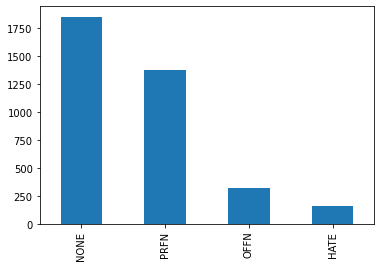

In [ ]:
tweets = train_data['text']
labels = train_data['task2']

labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())

NONE    414
PRFN    293
OFFN     82
HATE     25
Name: task2, dtype: int64


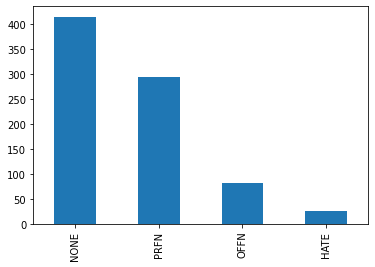

In [ ]:
labels1 = test_data['task2']

labels_count = labels1.value_counts()
labels_count.plot(kind="bar")
print(labels1.value_counts())

In [ ]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # remove consecutive letters to single letter at end
    text = re.sub(r'(.)\1+$', r'\1', text)
    
    # Return a list of words
    return(text)


In [ ]:
train_data['text'] = train_data['text'].apply((lambda x: re.sub('RT ','',x)))
cleanedText = []
for text in train_data["text"].values:
    text = text+" "
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'(@){1}.+?( ){1}', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'(#){1}.+?( ){1}', ' ', text, flags=re.MULTILINE)
    cleanedText.append(text_to_wordlist(text))
train_data['text'] = cleanedText

train_data.head()

,tweet_id,text,task1,task2,ID
0,1.123757e+18,hate wen females hit ah nigga with tht bro i m...,HOF,PRFN,hasoc_2020_en_2574
1,1.123733e+18,when you are from the bay but you are really a...,HOF,PRFN,hasoc_2020_en_3627
2,1.123734e+18,dear democrats : the american people aren t st...,NOT,NONE,hasoc_2020_en_3108
3,1.126951e+18,he ain t on drugs he just bored i be doing the...,HOF,PRFN,hasoc_2020_en_3986
4,1.126864e+18,summer 19 i m coming for you ! no boring shit ...,NOT,NONE,hasoc_2020_en_5152


In [ ]:
test_data['text'] = test_data['text'].apply((lambda x: re.sub('RT ','',x)))
cleanedText = []
for text in test_data["text"].values:
    text = text+" "
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'(@){1}.+?( ){1}', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'(#){1}.+?( ){1}', ' ', text, flags=re.MULTILINE)
    cleanedText.append(text_to_wordlist(text))
test_data['text'] = cleanedText

test_data.head()

,tweet_id,text,task1,task2,ID
0,1130081762154090497,samini resetting the show and moving things al...,NOT,NONE,hasoc_2020_en_2713
1,1130048316807491584,how do you know that he s left,HOF,NONE,hasoc_2020_en_3874
2,1123657766143504386,tried to get divock origi on a free seeing as ...,NOT,NONE,hasoc_2020_en_281
3,1126782963042013186,that is yalls stupid white ass reactions meeti...,HOF,PRFN,hasoc_2020_en_2026
4,1130159113529434113,amp; it did but a bitch got big girls things ...,HOF,PRFN,hasoc_2020_en_4023


In [ ]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip

--2020-09-17 11:20:52--  http://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip [following]
--2020-09-17 11:20:52--  https://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.twitter.27B.zip [following]
--2020-09-17 11:20:52--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting respon

In [ ]:
!unzip glove*.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


In [ ]:
!ls
!pwd

drive			    glove.twitter.27B.25d.txt  sample_data
glove.twitter.27B.100d.txt  glove.twitter.27B.50d.txt
glove.twitter.27B.200d.txt  glove.twitter.27B.zip
/content


In [ ]:
f = open('glove.twitter.27B.200d.txt')
embedd_index = {}
for line in f:
    val = line.split()
    word = val[0]
    coff = np.asarray(val[1:],dtype = 'float')
    embedd_index[word] = coff

f.close()
print('Found %s word vectors.' % len(embedd_index))

Found 1193515 word vectors.


In [ ]:
data = pd.concat([train_data, test_data], ignore_index=True)

print( len(train_data) ,' ' , len(test_data) , ' ', len(data)) 

3708   814   4522


In [ ]:
sentences = data['text']
tokenizer = Tokenizer(num_words = 3000)
tokenizer.fit_on_texts(sentences)
sequence = tokenizer.texts_to_sequences(sentences)

In [ ]:
embed_num_dims = 200
max_seq_len = 3000

index_of_words = tokenizer.word_index
print("No of unique words : ",len(index_of_words))

X = pad_sequences(sequence , maxlen = max_seq_len )

print(X)

No of unique words :  8974
[[   0    0    0 ...   14  274  379]
 [   0    0    0 ...   42  338  173]
 [   0    0    0 ...   57  516  244]
 ...
 [   0    0    0 ...    4    2  203]
 [   0    0    0 ... 2852    6   41]
 [   0    0    0 ...  210 1561  720]]


In [ ]:
embedding_matrix = np.zeros((len(index_of_words) + 1, embed_num_dims))

tokens = []
labels = []

for word,i in index_of_words.items():
    temp = embedd_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp

In [ ]:
Y = pd.get_dummies(data['task2']).values

In [ ]:
X_train = X[ : len(train_data)]
Y_train = Y[ : len(train_data)]

X_test = X[len(train_data) : ]
Y_test = Y[len(train_data) : ]

In [ ]:
embedd_layer = Embedding(len(index_of_words) + 1 , embed_num_dims , input_length = max_seq_len , weights = [embedding_matrix])

In [ ]:
from keras.layers import GRU, Bidirectional
model1 = Sequential()
model1.add(embedd_layer)
model1.add(Bidirectional(GRU(128)))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(4, activation='softmax'))
model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3000, 200)         1795000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               253440    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 2,081,852
Trainable params: 2,081,852
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("hasoc_b.h5", monitor='val_loss', verbose=1, save_best_only=True,
save_weights_only=False, mode='auto')

In [ ]:
model1.fit(X_train,Y_train , epochs = 10 ,validation_data=(X_test,Y_test) , callbacks=[checkpoint])

Epoch 1/10
116/116 [==============================] - ETA: 0s - loss: 0.7881 - accuracy: 0.7168
Epoch 00001: val_loss improved from inf to 0.59445, saving model to hasoc_b.h5
116/116 [==============================] - 31s 270ms/step - loss: 0.7881 - accuracy: 0.7168 - val_loss: 0.5945 - val_accuracy: 0.8256
Epoch 2/10
116/116 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.8228
Epoch 00002: val_loss improved from 0.59445 to 0.58284, saving model to hasoc_b.h5
116/116 [==============================] - 31s 265ms/step - loss: 0.5420 - accuracy: 0.8228 - val_loss: 0.5828 - val_accuracy: 0.8292
Epoch 3/10
116/116 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.8398
Epoch 00003: val_loss did not improve from 0.58284
116/116 [==============================] - 31s 263ms/step - loss: 0.4712 - accuracy: 0.8398 - val_loss: 0.5892 - val_accuracy: 0.8268
Epoch 4/10
116/116 [==============================] - ETA: 0s - loss: 0.3748 - accuracy: 0.8730
E

In [ ]:
model1.load_weights('hasoc_b.h5')
model1.evaluate(X_test,Y_test)

26/26 [==============================] - 2s 94ms/step - loss: 0.5828 - accuracy: 0.8292


[0.5828446745872498, 0.8292383551597595]

In [ ]:
Y_pred = model1.predict(X_test)

In [ ]:
Y_pred[:5]

array([[0.01619411, 0.93824863, 0.03218688, 0.0133704 ],
       [0.01631872, 0.94160664, 0.01874951, 0.02332505],
       [0.01147001, 0.9384041 , 0.00752973, 0.0425962 ],
       [0.05002758, 0.0203138 , 0.091448  , 0.8382107 ],
       [0.02999772, 0.04784138, 0.04138844, 0.8807725 ]], dtype=float32)

In [ ]:
classes = ['HATE','NONE','OFFN','PRFN']

In [ ]:
import numpy as np
pred_class = []
for item in Y_pred:
  ind = np.argmax(item)
  pred_class.append(classes[ind])
print(pred_class)

['NONE', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE', 'PRFN', 'PRFN', 'OFFN', 'PRFN', 'PRFN', 'PRFN', 'PRFN', 'NONE', 'PRFN', 'OFFN', 'PRFN', 'PRFN', 'NONE', 'PRFN', 'NONE', 'PRFN', 'NONE', 'NONE', 'PRFN', 'PRFN', 'PRFN', 'PRFN', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'PRFN', 'PRFN', 'PRFN', 'NONE', 'PRFN', 'PRFN', 'PRFN', 'PRFN', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'PRFN', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'PRFN', 'NONE', 'PRFN', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'PRFN', 'NONE', 'PRFN', 'NONE', 'NONE', 'OFFN', 'PRFN', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE', 'NONE', 'PRFN', 'NONE', 'NONE', 'OFFN', 'PRFN', 'NONE', 'PRFN', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE', 'NONE', 'NONE', 'PRFN', 'PRFN', 'NONE', 'NONE', 'NONE', 'PRFN', 'NONE', 'PRFN', 'PRFN', 'PRFN', 'PRFN',

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_data['task2'] , pred_class))

              precision    recall  f1-score   support

        HATE       0.00      0.00      0.00        25
        NONE       0.87      0.96      0.91       414
        OFFN       0.69      0.11      0.19        82
        PRFN       0.78      0.92      0.84       293

    accuracy                           0.83       814
   macro avg       0.59      0.50      0.49       814
weighted avg       0.79      0.83      0.79       814



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_data = pd.DataFrame()

pred_data['tweet_id'] = test_data['tweet_id']
pred_data['task2'] = pred_class
pred_data['ID'] = test_data['ID']

compression_opts = dict(method='zip',archive_name='submission_EN_B.csv')
pred_data.to_csv('submission-gru-b.zip', index=False, compression=compression_opts)
print(pred_data)

                tweet_id task2                  ID
0    1130081762154090497  NONE  hasoc_2020_en_2713
1    1130048316807491584  NONE  hasoc_2020_en_3874
2    1123657766143504386  NONE   hasoc_2020_en_281
3    1126782963042013186  PRFN  hasoc_2020_en_2026
4    1130159113529434113  PRFN  hasoc_2020_en_4023
..                   ...   ...                 ...
809  1127061607433900032  NONE  hasoc_2020_en_1212
810  1123685826074951681  PRFN  hasoc_2020_en_3435
811  1126882552587927552  NONE  hasoc_2020_en_3987
812  1130294488859996160  NONE  hasoc_2020_en_1176
813  1130111650780991493  NONE  hasoc_2020_en_1937

[814 rows x 3 columns]
